<a href="https://colab.research.google.com/github/jakubmensik989/POCL/blob/main/Dataset_Relation_Analysis_20260127.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data successfully load！
合并后的数据维度: (558211, 38)


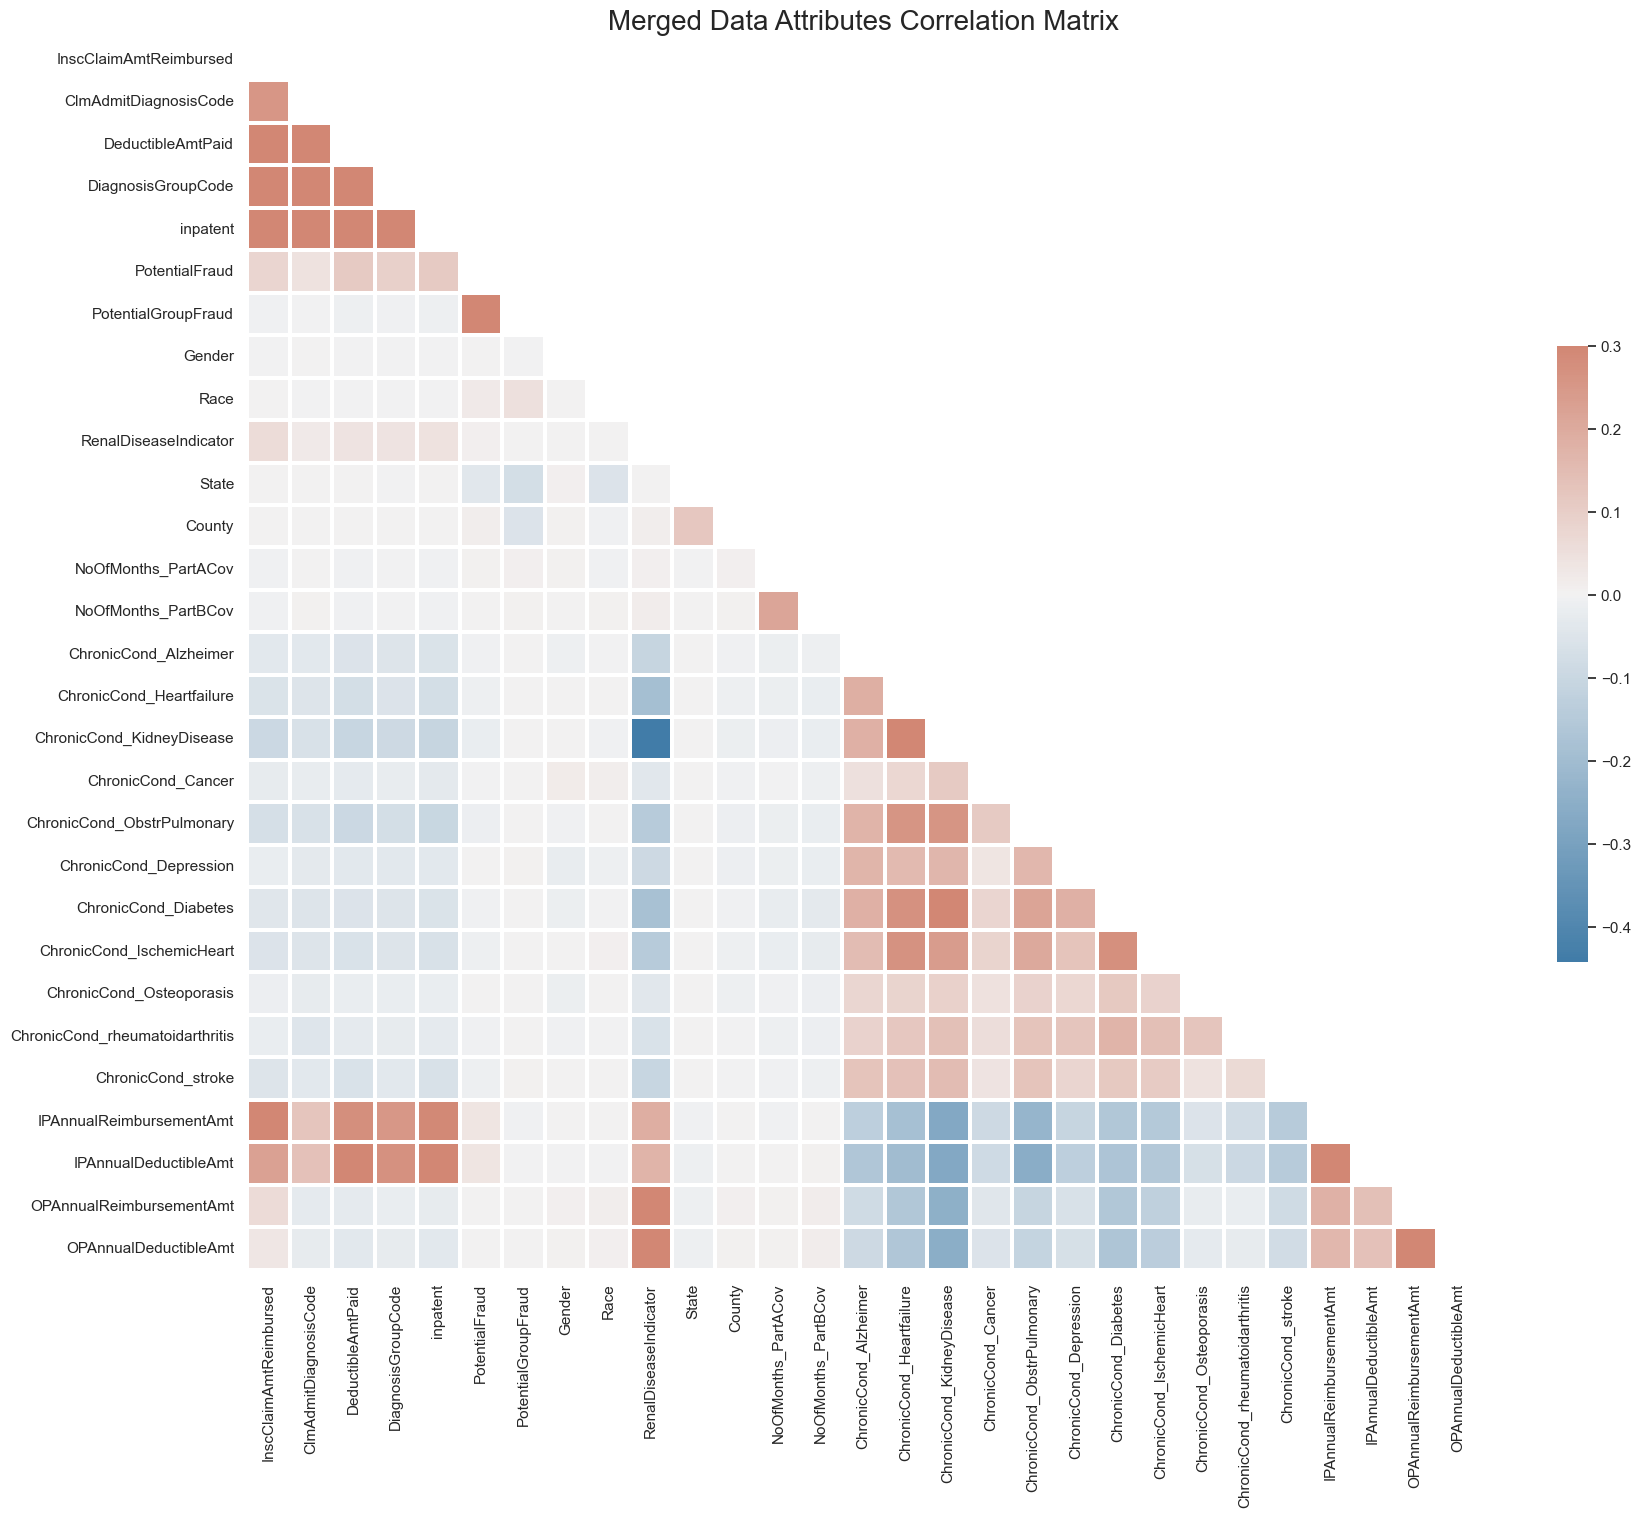


--- Top 20 Correlated Attribute Pairs ---
inpatent                   DeductibleAmtPaid            0.986365
DiagnosisGroupCode         inpatent                     0.849097
OPAnnualDeductibleAmt      OPAnnualReimbursementAmt     0.837335
DiagnosisGroupCode         DeductibleAmtPaid            0.836606
inpatent                   InscClaimAmtReimbursed       0.665122
InscClaimAmtReimbursed     DeductibleAmtPaid            0.653980
IPAnnualReimbursementAmt   IPAnnualDeductibleAmt        0.642743
PotentialGroupFraud        PotentialFraud               0.630034
InscClaimAmtReimbursed     DiagnosisGroupCode           0.572313
ChronicCond_KidneyDisease  RenalDiseaseIndicator        0.442357
ClmAdmitDiagnosisCode      inpatent                     0.388884
InscClaimAmtReimbursed     IPAnnualReimbursementAmt     0.383701
ClmAdmitDiagnosisCode      DeductibleAmtPaid            0.383661
OPAnnualDeductibleAmt      RenalDiseaseIndicator        0.342015
OPAnnualReimbursementAmt   RenalDiseaseIndicato

In [ ]:
#Dataset_01_ds_01
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. load the dataset
try:
    claims_df = pd.read_csv('claims.csv')
    bene_df = pd.read_csv('bene.csv')
    print("data successfully load！")
except FileNotFoundError as e:
    print(f"错误：找不到文件。请检查文件名和路径。\n{e}")

# 2. 合并数据集
# 使用 'BeneID' 作为key将两个表进行内连接
merged_df = pd.merge(claims_df, bene_df, on='BeneID', how='inner')
print(f"合并后的数据维度: {merged_df.shape}")

# 3. 数据预处理与特征选择
# 排除 ID、日期等不适合做相关性分析的列
cols_to_exclude = [
    'ClaimID', 'BeneID', 'ClaimStartDt', 'ClaimEndDt',
    'AdmissionDt', 'DischargeDt', 'DOB', 'DOD', 'Provider'
]

# 选择数值型列进行分析
numerical_cols = [
    col for col in merged_df.columns
    if col not in cols_to_exclude and merged_df[col].dtype in ['int64', 'float64']
]

# 4. calculate corelation matrix
corr_matrix = merged_df[numerical_cols].corr()

# 5. 可视化：绘制相关性热力图
# 设置画布大小
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 设置颜色映射
cmap = sns.diverging_palette(240, 20, as_cmap=True)

# 绘制热力图
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1.5, cbar_kws={"shrink": .5}, annot=False)

plt.title('Merged Data Attributes Correlation Matrix', fontsize=20)
plt.show()

# 6. 分析：找出相关性最强的属性对
# 将相关性矩阵展开并排序
corr_unstacked = corr_matrix.abs().unstack()
sorted_corr = corr_unstacked.sort_values(ascending=False)

# 排除自身与自身的相关性 (即相关系数为 1.0 的)
top_corr = sorted_corr[sorted_corr < 1.0]

# 打印前 20 个相关性最强的对（去除重复对）
print("\n--- Top 20 Correlated Attribute Pairs ---")
print(top_corr[::2].head(20))

# 7. 特定分析：查看与 'PotentialFraud' (潜在欺诈) 最相关的特征
print("\n--- Correlation with PotentialFraud ---")
print(corr_matrix['PotentialFraud'].sort_values(ascending=False).head(10))

In [ ]:
# 1. 选择分析所用的数值列
origin_data = merged_df[numerical_cols]
# 2. 将其保存为一个新的 CSV 文件，不包含索引
origin_data.to_csv('ready_for_origin.csv', index=False)
print("已成功生成 'ready_for_origin.csv'，请使用此文件在 Origin 中绘图。")

已成功生成 'ready_for_origin.csv'，请使用此文件在 Origin 中绘图。


In [ ]:
import os
print(os.getcwd())

C:\Users\1


数据准备完成！


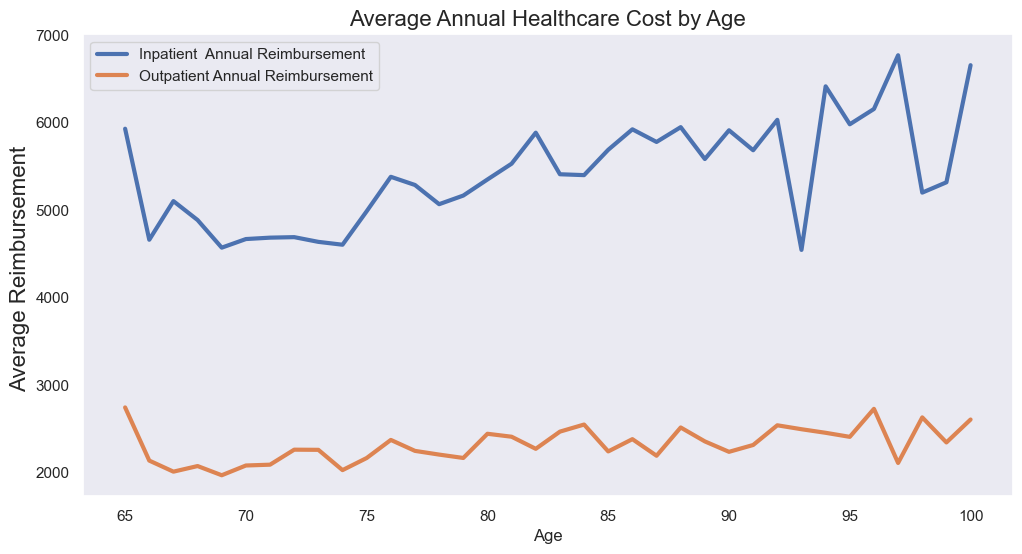

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 数据准备
try:
    claims_df = pd.read_csv('claims.csv')
    bene_df = pd.read_csv('bene.csv')

    # 合并数据
    merged_df = pd.merge(claims_df, bene_df, on='BeneID', how='inner')

    # 转换日期格式
    date_cols = ['ClaimStartDt', 'ClaimEndDt', 'DOB']
    for col in date_cols:
        merged_df[col] = pd.to_datetime(merged_df[col])

    # 计算年龄 (假设当前数据年份约为2009年)
    merged_df['Age'] = 2009 - merged_df['DOB'].dt.year

    print("数据准备完成！")

except Exception as e:
    print(f"数据加载出错: {e}")

sns.set(style="dark")

#与医疗费用的关系 (折线图)
# 按年龄分组计算平均费用
age_cost = merged_df.groupby('Age')[['IPAnnualReimbursementAmt', 'OPAnnualReimbursementAmt']].mean().reset_index()

# 过滤掉异常年龄 (例如只看 65-100 岁，因为是 Medicare 数据)
age_cost = age_cost[(age_cost['Age'] >= 65) & (age_cost['Age'] <= 100)]

plt.figure(figsize=(12, 6))
plt.plot(age_cost['Age'], age_cost['IPAnnualReimbursementAmt'], label='Inpatient  Annual Reimbursement', linewidth=3)
plt.plot(age_cost['Age'], age_cost['OPAnnualReimbursementAmt'], label='Outpatient Annual Reimbursement', linewidth=3)
plt.title('Average Annual Healthcare Cost by Age', fontsize=16)
plt.xlabel('Age')
plt.ylabel('Average Reimbursement ',fontsize=16)
plt.legend()
plt.show()






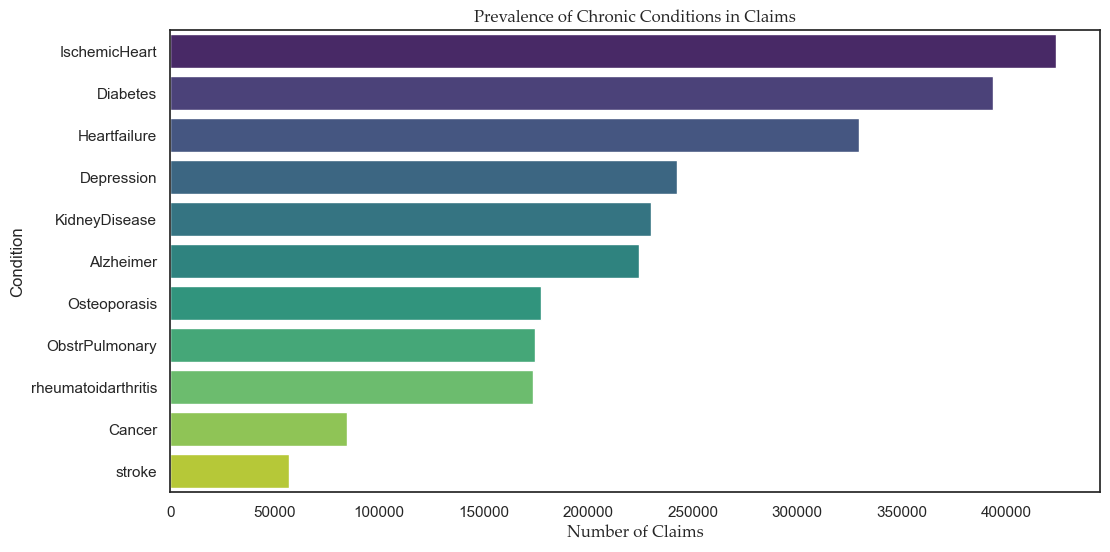

In [ ]:
# 分析 2: 慢性病流行度分析
# 找出所有慢性病列
chronic_cols = [col for col in bene_df.columns if 'ChronicCond' in col]
condition_counts = {}

for col in chronic_cols:
    count = merged_df[merged_df[col] == 1].shape[0]
    name = col.replace('ChronicCond_', '')
    condition_counts[name] = count

# 转换为DataFrame并排序
conditions_df = pd.DataFrame(list(condition_counts.items()), columns=['Condition', 'Count'])
conditions_df = conditions_df.sort_values('Count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Condition', data=conditions_df, palette='viridis')
plt.title('Prevalence of Chronic Conditions in Claims', fontsize=14, font="palatino linotype")
plt.xlabel('Number of Claims', font="palatino linotype")
plt.show()

数据加载成功！
最终用于分析的member count: 77289


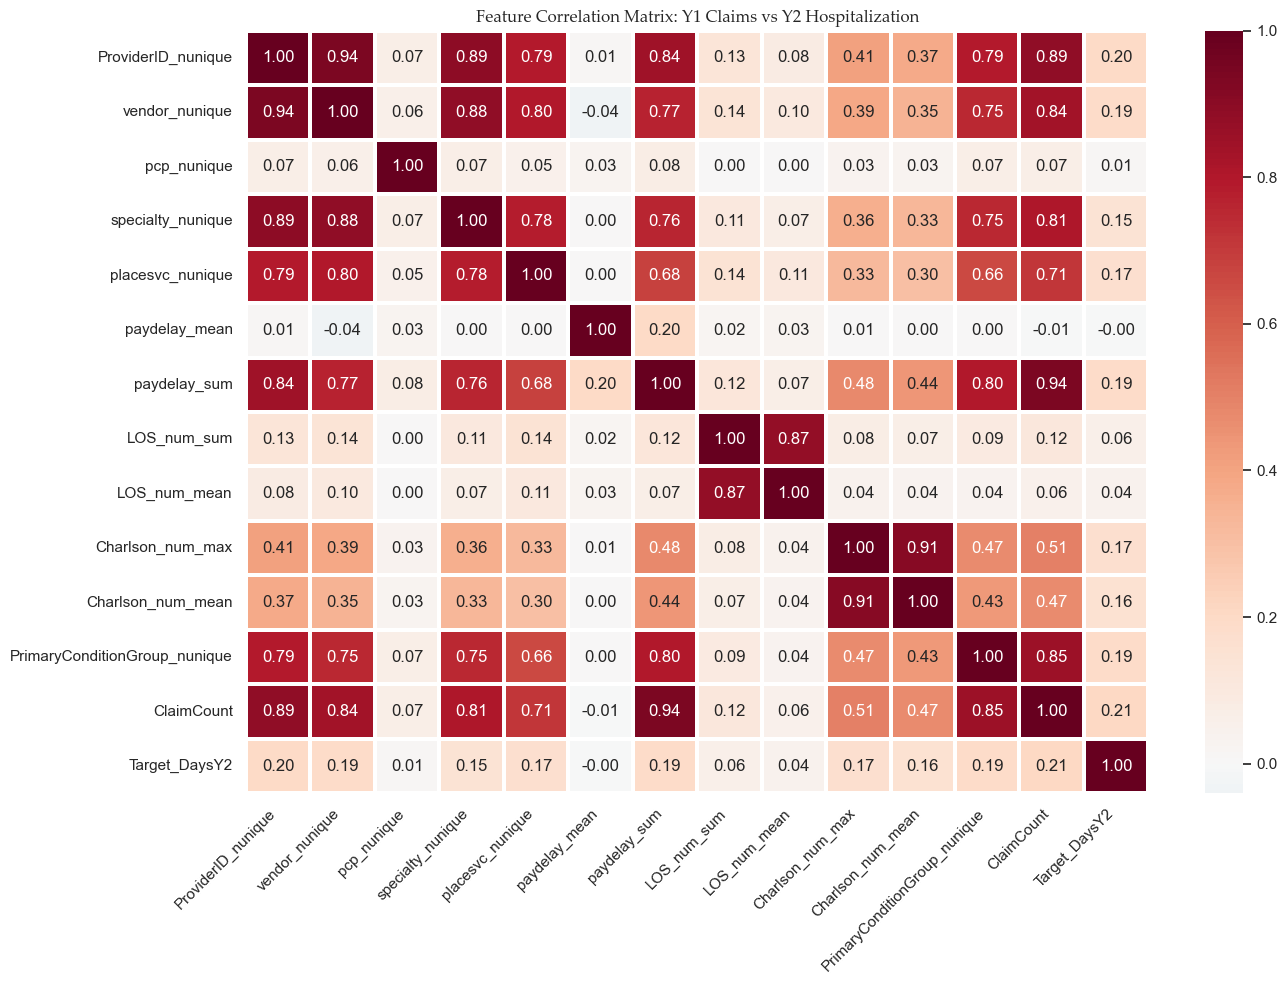


---哪些因素與第二年住院天數 (Target_DaysY2) 最相關? ---
Target_DaysY2                    1.000000
ClaimCount                       0.207071
ProviderID_nunique               0.198412
paydelay_sum                     0.193323
vendor_nunique                   0.192109
PrimaryConditionGroup_nunique    0.188758
Charlson_num_max                 0.170634
placesvc_nunique                 0.166937
Charlson_num_mean                0.158372
specialty_nunique                0.150488
Name: Target_DaysY2, dtype: float64


In [ ]:
#Dataset_2_ds02 Analysis
#针对 Claims_Y1.csv和DayInHospital_Y2.csv ，分析第一年的详细理赔行为（科室、诊断、费用、住院时长）与第二年住院天数间的关系

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 使用 Claims_Y1 和 DayInHospital_Y2 进行匹配
try:
    claims = pd.read_csv('Claims_Y1.csv')
    target = pd.read_csv('DayInHospital_Y2.csv')
    print("数据加载成功！")
except FileNotFoundError as e:
    print(f"错误：找不到文件。{e}")

# 2. 数据清洗
# 2.1 处理 'LengthOfStay' (住院时长) 的文本格式，转换为数值天数
los_map = {
    '1 day': 1, '2 days': 2, '3 days': 3, '4 days': 4, '5 days': 5, '6 days': 6,
    '1- 2 weeks': 10.5, '2- 4 weeks': 21, '4- 8 weeks': 42, '8-12 weeks': 70,
    '12-26 weeks': 133, '26+ weeks': 182
}

# 2.2 处理 'CharlsonIndex'
charlson_map = {'0': 0, '1-2': 1.5, '3-4': 3.5, '5+': 5}

# 应用映射
claims['LOS_num'] = claims['LengthOfStay'].map(los_map).fillna(0)
claims['Charlson_num'] = claims['CharlsonIndex'].map(charlson_map)

# 3.Data Aggregation
# 将交易级别的理赔数据聚合为会员级别的特征
agg_funcs = {
    'ProviderID': 'nunique',       # 看过多少个不同的医生
    'vendor': 'nunique',           # 涉及多少个不同的供应商
    'pcp': 'nunique',              # 涉及多少个初级保健医生
    'specialty': 'nunique',        # 涉及多少个不同的专科
    'placesvc': 'nunique',         # 在多少个不同类型的场所就诊
    'paydelay': ['mean', 'sum'],   # 支付延迟的平均值和总和
    'LOS_num': ['sum', 'mean'],    # 总住院天数和平均住院天数
    'Charlson_num': ['max', 'mean'], # 最严重的合并症指数
    'PrimaryConditionGroup': 'nunique', # 患有多少种不同的主要疾病
    'Year': 'size'                 # 理赔总次数 (Claim Count)
}

# 按memberID分组聚合
claims_agg = claims.groupby('MemberID').agg(agg_funcs)

# 重命名列名
claims_agg.columns = ['_'.join(col).strip() for col in claims_agg.columns.values]
claims_agg.rename(columns={'Year_size': 'ClaimCount'}, inplace=True)
claims_agg.reset_index(inplace=True)

target.rename(columns={'memberid': 'MemberID', 'DaysInHospital_Y2': 'Target_DaysY2'}, inplace=True)

# 执行内连接 (Inner Join)
merged_df = pd.merge(claims_agg, target, on='MemberID', how='inner')
merged_df.fillna(0, inplace=True)

print(f"最终用于分析的member count: {merged_df.shape[0]}")

# 5. 计算相关性并可视化
# 计算相关系数矩阵
corr_matrix = merged_df.drop('MemberID', axis=1).corr()

# 绘制热力图
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".2f", center=0, linewidths=1.5)
plt.title('Feature Correlation Matrix: Y1 Claims vs Y2 Hospitalization', fontsize=16, font="palatino linotype")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 6. 输出与目标变量最相关的特征
print("\n---哪些因素與第二年住院天數 (Target_DaysY2) 最相關? ---")
print(corr_matrix['Target_DaysY2'].sort_values(ascending=False).head(10))





数据加载成功。
化验数据包含: 64855 人
目标数据包含: 76038 人
最终匹配人数: 64855


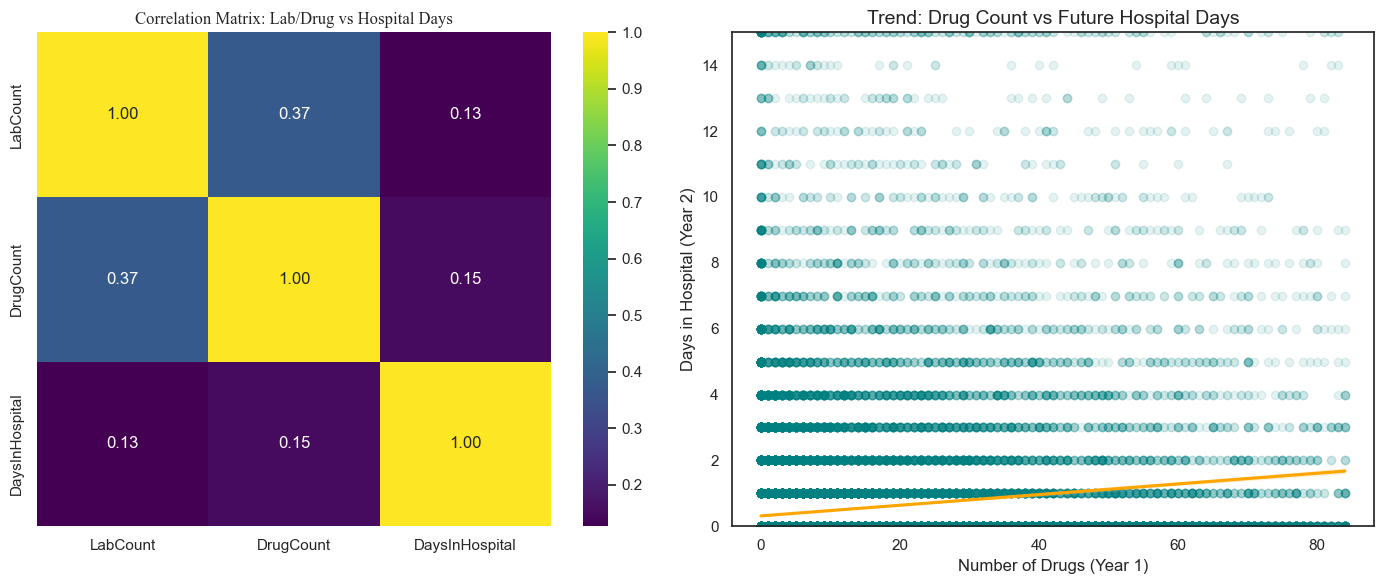

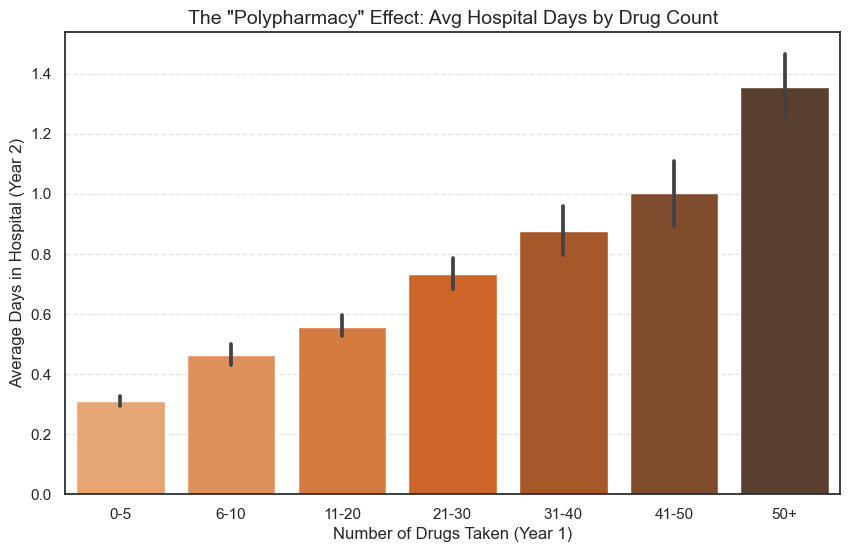

In [ ]:
#针对 DaysinHosptal 和 Lab/Drug count Analysis

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 加载数据
try:
    lab_drug = pd.read_csv('lab_drug.csv', sep='\t')
    target_b = pd.read_csv('DaysInHospital_Y2.csv')

    print("数据加载成功。")
    print(f"化验数据包含: {lab_drug.shape[0]} 人")
    print(f"目标数据包含: {target_b.shape[0]} 人")

except Exception as e:
    print(f"文件加载错误: {e}")

# 2. 数据合并
# 通过 MemberID 进行内连接
merged_b = pd.merge(lab_drug, target_b, on='MemberID', how='inner')
print(f"最终匹配人数: {merged_b.shape[0]}")

# 3. 基础相关性分析
cols_to_analyze = ['LabCount', 'DrugCount', 'DaysInHospital']
corr = merged_b[cols_to_analyze].corr()

# 4. 可视化 1: 整体关系概览
plt.figure(figsize=(14, 6))

# 图 1: 热力图
plt.subplot(1, 2, 1)
sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix: Lab/Drug vs Hospital Days', fontsize=14, font="times new roman")

# 图 2: 散点趋势图 (带回归线)
plt.subplot(1, 2, 2)
sns.regplot(x='DrugCount', y='DaysInHospital', data=merged_b,
            scatter_kws={'alpha': 0.1, 'color': 'teal'}, line_kws={'color': 'orange'})
plt.title('Trend: Drug Count vs Future Hospital Days', fontsize=14)
plt.ylim(0, 15)
plt.xlabel('Number of Drugs (Year 1)')
plt.ylabel('Days in Hospital (Year 2)')

plt.tight_layout()
plt.show()

# 5.visulaization2:
# 将药品数量分成不同的区间，观察风险是否线性增加
merged_b['DrugCount_Bin'] = pd.cut(merged_b['DrugCount'],
                                   bins=[0, 5, 10, 20, 30, 40, 50, 200],
                                   labels=['0-5', '6-10', '11-20', '21-30', '31-40', '41-50', '50+'])

plt.figure(figsize=(10, 6))
# 绘制每个区间的平均住院天数
sns.barplot(x='DrugCount_Bin', y='DaysInHospital', data=merged_b, palette='Oranges_d')
plt.title('The "Polypharmacy" Effect: Avg Hospital Days by Drug Count', fontsize=14)
plt.ylabel('Average Days in Hospital (Year 2)')
plt.xlabel('Number of Drugs Taken (Year 1)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()



#left figure:LabCount, DrugCount 和 DaysInHospital 之间的相关系数
#right figure: 药品数量越多，住院天数呈上升趋势
#当处方药数量超过 40-50 时，住院风险呈现显著的非线性上升。

数据加载成功。
LabCount 与 住院天数的相关系数: 0.1268


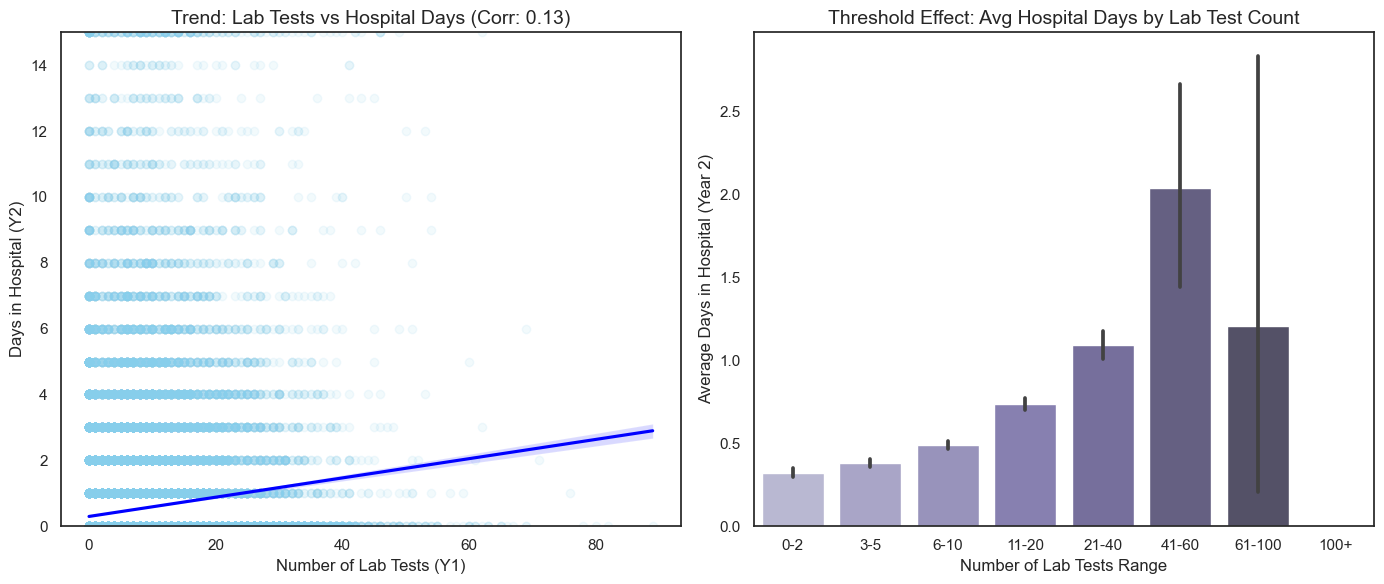

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 加载数据
try:
    # 读取化验数据
    lab_drug = pd.read_csv('lab_drug.csv', sep='\t')
    # 读取目标数据
    target_b = pd.read_csv('DaysInHospital_Y2.csv')
    print("数据加载成功。")
except Exception as e:
    print(f"读取错误: {e}")

# 2. 合并数据
merged_b = pd.merge(lab_drug, target_b, on='MemberID', how='inner')

# 3. 计算 Lab Count 相关性
corr_lab = merged_b[['LabCount', 'DaysInHospital']].corr().iloc[0, 1]
print(f"LabCount 与 住院天数的相关系数: {corr_lab:.4f}")

# 4. 可视化分析
plt.figure(figsize=(14, 6))

# --- 左图: 散点趋势图 ---
plt.subplot(1, 2, 1)
sns.regplot(x='LabCount', y='DaysInHospital', data=merged_b,
            scatter_kws={'alpha': 0.1, 'color': 'skyblue'},
            line_kws={'color': 'blue'})
plt.title(f'Trend: Lab Tests vs Hospital Days (Corr: {corr_lab:.2f})', fontsize=14)
plt.ylim(0, 15) # 聚焦于大多数人的情况
plt.xlabel('Number of Lab Tests (Y1)')
plt.ylabel('Days in Hospital (Y2)')

# --- 右图: 分箱分析---
# 根据 LabCount 的数据分布 (max~90) 设定分箱
# 0-2: 健康人/体检
# 3-10: 轻微/偶发
# 11-40: 慢性病监控
# 41+: 重症/高频监控
bins = [0, 2, 5, 10, 20, 40, 60, 100, 200]
labels = ['0-2', '3-5', '6-10', '11-20', '21-40', '41-60', '61-100', '100+']
merged_b['LabCount_Bin'] = pd.cut(merged_b['LabCount'], bins=bins, labels=labels)

plt.subplot(1, 2, 2)
sns.barplot(x='LabCount_Bin', y='DaysInHospital', data=merged_b, palette='Purples_d')
plt.title('Threshold Effect: Avg Hospital Days by Lab Test Count', fontsize=14)
plt.xlabel('Number of Lab Tests Range')
plt.ylabel('Average Days in Hospital (Year 2)')

plt.tight_layout()
plt.show()

In [ ]:
#Dataset_3 Analysis_ds_03

import pandas as pd
import numpy as np

# 1. 加载数据
df = pd.read_csv('Dataset of health insurance portfolio.csv')

# 2. 数据清洗
# 删除关键列中有缺失值的行（约占总数据的 5%），保证分析准确性
df_clean = df.dropna(subset=['C_GI', 'C_II', 'C_C', 'age', 'premium', 'cost_claims_year']).copy()

# 3. Feature Engineering
# 将 'lapse' (流失) 转换为 0/1 格式
# 假设原数据中 1 代表流失
df_clean['is_lapsed'] = df_clean['lapse'].apply(lambda x: 1 if x == 1 else 0)

# 将性别转换为数值 (男性=1, 女性=0)
df_clean['gender_code'] = df_clean['gender'].apply(lambda x: 1 if x == 'M' else 0)

# 将气候区 (C1-C6) 映射为数字，以便计算相关性
climate_map = {'C1': 1, 'C2': 2, 'C3': 3, 'C4': 4, 'C5': 5, 'C6': 6}
df_clean['climate_code'] = df_clean['C_C'].map(climate_map)

print(f"数据清洗完成！剩余有效数据: {df_clean.shape[0]} 条")


数据清洗完成！剩余有效数据: 215428 条


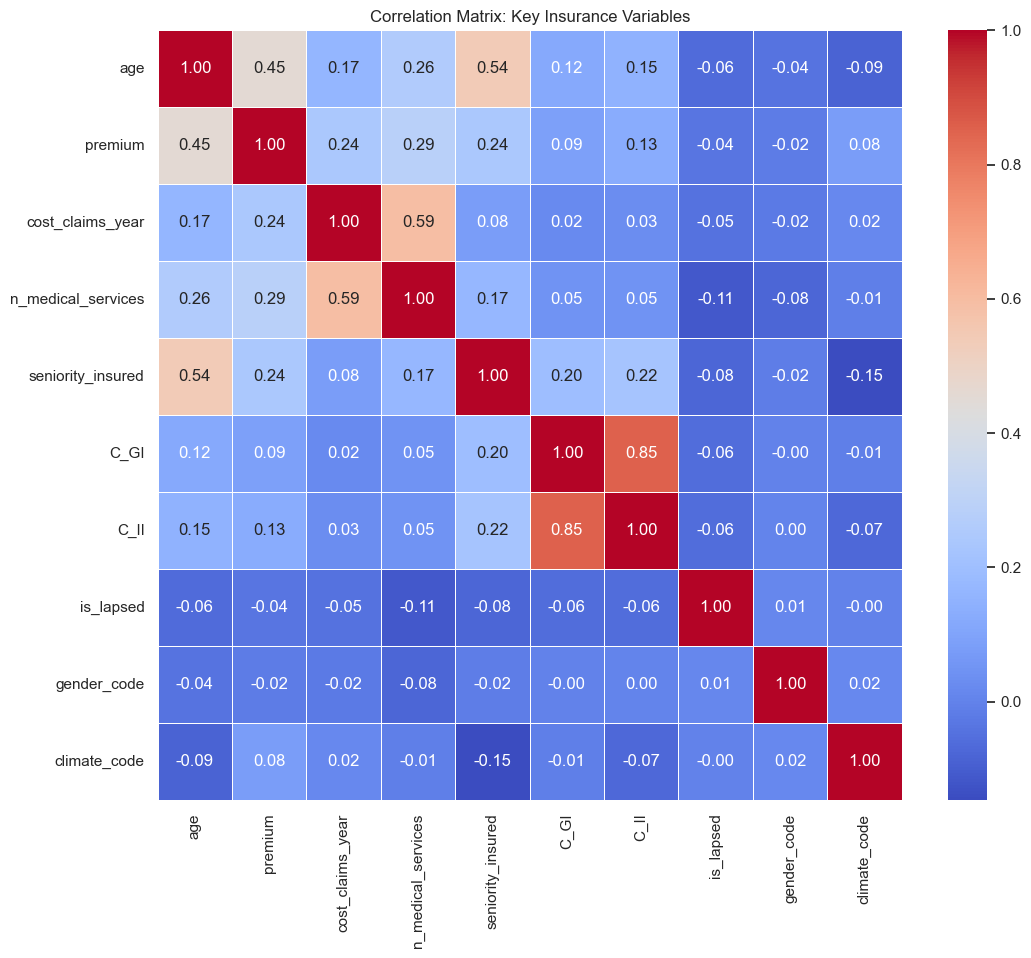

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 选择要分析的列
corr_cols = [
    'age', 'premium', 'cost_claims_year', 'n_medical_services', 'seniority_insured', # 核心业务指标
    'C_GI', 'C_II',  # 收入指标
    'is_lapsed', 'gender_code', 'climate_code' # 分类指标
]

# 2. 计算相关系数矩阵
corr_matrix = df_clean[corr_cols].corr()

# 3. 绘制热力图
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,       # 显示具体数字
            cmap='coolwarm',  # 红蓝配色 (红色正相关，蓝色负相关)
            fmt=".2f",        # 保留两位小数
            linewidths=.5)    # 格子之间留点空隙

plt.title('Correlation Matrix: Key Insurance Variables')
plt.show()

C:\Users\1\AppData\Local\Temp\ipykernel_40196\4262750383.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='age', y='cost_claims_year', data=df_clean,


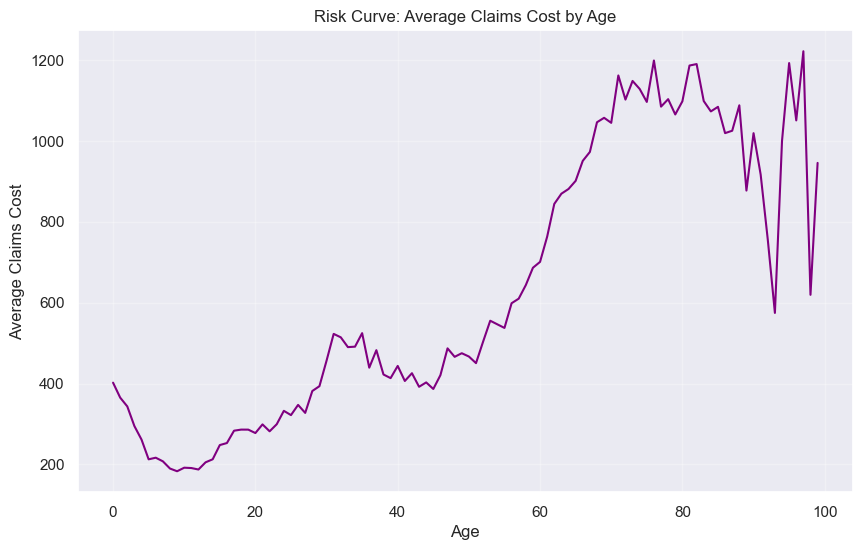

In [ ]:
plt.figure(figsize=(10, 6))

# 绘制线图，展示随年龄变化的平均赔付成本
sns.lineplot(x='age', y='cost_claims_year', data=df_clean,
             color='purple', ci=None)

plt.title('Risk Curve: Average Claims Cost by Age')
plt.xlabel('Age')
plt.ylabel('Average Claims Cost')
plt.grid(True, alpha=0.3)
plt.show()

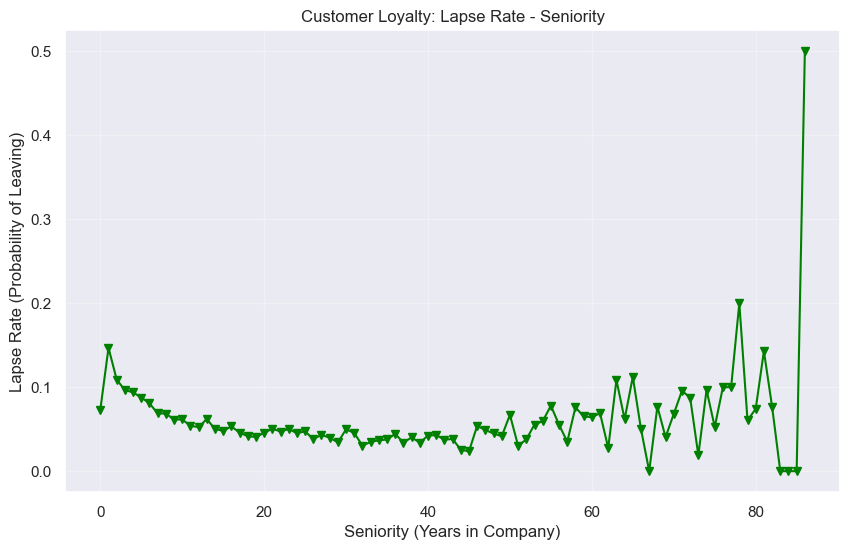

In [ ]:
#流失率与老客户之间的关系 (Lapse-Seniority）

plt.figure(figsize=(10, 6))

# 先按“入保年限”分组，计算每组的流失率(平均值)
lapse_rate_by_tenure = df_clean.groupby('seniority_insured')['is_lapsed'].mean()

# 画图
lapse_rate_by_tenure.plot(marker='v', color='green')

plt.title('Customer Loyalty: Lapse Rate - Seniority')
plt.xlabel('Seniority (Years in Company)')
plt.ylabel('Lapse Rate (Probability of Leaving)')
plt.grid(True, alpha=0.3)
plt.show()